### Outline

#### 1. Generation of synthetic data.

This would typically be done using something like ```bliss mode=generate``` from the command line. This calls the ```generate``` function within ```bliss/main.py```, using the default ```DictConfig``` object specified by the various ```.yaml``` files.

The code below loads the file ```redshift.yaml``` from ```case_studies/redshift_estimation``` as a DictConfig for use by ```hydra```. You may have to change some absolute and relative paths to get this to load for you.

In [28]:
import sys
import os

In [29]:
os.getcwd()

'/home/declan/current/bliss'

In [30]:
os.chdir('/home/declan/current/bliss')

In [31]:
from bliss.encoder.variational_dist import VariationalDistSpec, VariationalDist
from bliss.encoder.unconstrained_dists import UnconstrainedNormal
import torch
import numpy as np
from os import environ
from pathlib import Path
from hydra import initialize, compose
from hydra.utils import instantiate
import matplotlib.pyplot as plt
from omegaconf import DictConfig, OmegaConf
from bliss.catalog import TileCatalog

In [32]:
environ["BLISS_HOME"] = "/home/declan/current/bliss"
with initialize(config_path="../", version_base=None):
    cfg = compose("redshift", overrides={"surveys.sdss.load_image_data=true"})

In [33]:
type(cfg)

omegaconf.dictconfig.DictConfig

In [34]:
print(OmegaConf.to_yaml(cfg, resolve=False, sort_keys=False))

paths:
  root: ${oc.env:BLISS_HOME}
  data: ${paths.root}/data
  sdss: ${paths.data}/sdss
  decals: ${paths.data}/decals
  des: ${paths.data}/des
  dc2: ${paths.data}/dc2
  output: ${paths.root}/output
  pretrained_models: ${paths.data}/pretrained_models
prior:
  _target_: case_studies.redshift_estimation.prior.RedshiftPrior
  survey_bands:
  - u
  - g
  - r
  - i
  - z
  reference_band: 2
  star_color_model_path: ${simulator.survey.dir_path}/color_models/star_gmm_nmgy.pkl
  gal_color_model_path: ${simulator.survey.dir_path}/color_models/gal_gmm_nmgy.pkl
  n_tiles_h: 20
  n_tiles_w: 20
  tile_slen: 4
  batch_size: 64
  max_sources: 1
  mean_sources: 0.2
  min_sources: 0
  prob_galaxy: 0.72
  star_flux_exponent: 0.43
  star_flux_truncation: 640
  star_flux_loc: 0.0
  star_flux_scale: 0.63094948
  galaxy_flux_truncation: 1013
  galaxy_flux_exponent: 0.47
  galaxy_flux_scale: 0.6301037
  galaxy_flux_loc: 0.0
  galaxy_a_concentration: 0.39330758068481686
  galaxy_a_loc: 0.8371888967872619


You can browse the above printouts to get a feel for how the config is structured. Our project will eventually add some configurables and we'll have our own config similar to the above.

The ```generate``` function from ```bliss/main.py``` takes arguments as

```
def generate(gen_cfg: DictConfig):
   ...

```

and so we can plug in a given ```DictConfig``` like the above to generate data. The true ```generate``` function is much more complex than what is given below, and helps cache previously simulated data to save time, etc. Our altered function below is used only for illustration purposes, where we'll generate a single batch of simulated data.

In [35]:
cfg.generate

{'n_image_files': 16, 'n_batches_per_file': 16, 'simulator': '${simulator}', 'cached_data_path': '/data/scratch/declan/redshift_estimation', 'file_prefix': 'dataset'}

In [36]:
cfg.generate.simulator

{'_target_': 'case_studies.redshift_estimation.simulated_dataset.RedshiftSimulatedDataset', 'survey': '${surveys.sdss}', 'prior': '${prior}', 'n_batches': 128, 'use_coaddition': False, 'coadd_depth': 1, 'num_workers': 32, 'valid_n_batches': 10, 'fix_validation_set': True}

In [37]:
from case_studies.redshift_estimation.prior import RedshiftPrior
from case_studies.redshift_estimation.simulated_dataset import RedshiftSimulatedDataset

In [38]:
simulated_dataset = instantiate(cfg.generate.simulator)

In [10]:
def generate(gen_cfg: DictConfig):
    simulated_dataset = instantiate(gen_cfg.simulator, num_workers=0)

    for _ in range(1):
        batch = simulated_dataset.get_batch()
        
    return batch

##### ***Running the cell below will take several minutes*** 

In [10]:
simulated_batch_of_data = generate(cfg.generate)

Note that the 'full' configurable has three main subconfigs: `cfg.generate, cfg.train, cfg.predict`. This just helps keep things more organized. We only passed `cfg.generate` to the ```generate``` function.

In [11]:
simulated_batch_of_data.keys()

dict_keys(['tile_catalog', 'images', 'background', 'deconvolution', 'psf_params'])

The simulated batch is a ```dict``` object. These can be stored to disk in some fashion that we won't worry about right now (see ```generate``` function in ```bliss/main.py```), as we'll just work with this single batch. Let's examine some of the objects. The main objects produced are the tile catalogs and the images. Let's look at the attributes of the tile catalog.

In [12]:
tc = simulated_batch_of_data['tile_catalog']
tc.keys()

dict_keys(['locs', 'n_sources', 'source_type', 'galaxy_fluxes', 'galaxy_params', 'star_fluxes', 'redshifts'])

The quantities we're most interested in are `star_fluxes` and `galaxy_fluxes`. Checking shapes, we see that these have magnitudes corresponding to `u,g,r,i,z` bands. The bands are specified in the prior.

In [13]:
cfg.prior.survey_bands

['u', 'g', 'r', 'i', 'z']

In [14]:
tc['galaxy_fluxes'].shape, tc['star_fluxes'].shape

(torch.Size([64, 20, 20, 1, 5]), torch.Size([64, 20, 20, 1, 5]))

The first three dimensions of all these objects are 64 x 20 x 20. These numbers represent the following:
- 64 = number of synthetic (simulated) images
- 20 = number of tiles lengthwise
- 20 = number of tiles widthwise

BLISS operates by dividing a given images into *tiles* of a certain size. This can be thought of as parsing the image into bite-size pieces. The number of tiles and number of images in simulated batches are controllable from the config object, e.g. 

In [15]:
cfg.prior.batch_size, cfg.prior.n_tiles_h, cfg.prior.n_tiles_w

(64, 20, 20)

In [16]:
ims = simulated_batch_of_data['images']

In [17]:
ims.shape

torch.Size([64, 5, 80, 80])

As expected, there are 64 images. The dimension 5 does not correspond to the number of sources per tile, but rather to the *photometric band* of each image, corresponding to u,g,r,i,z for SDSS data. Read more here: https://www.sdss4.org/instruments/camera/#Filters

Again, these are specified in the config:

In [18]:
cfg.prior.survey_bands

['u', 'g', 'r', 'i', 'z']

We gather that each image for each band is 80 x 80. Recalling that we have 20 x 20 tiles, this implie that each tile is 4x4. Again, this is specified in the config.

In [19]:
cfg.prior.tile_slen

4

Let's examine some simulated images.

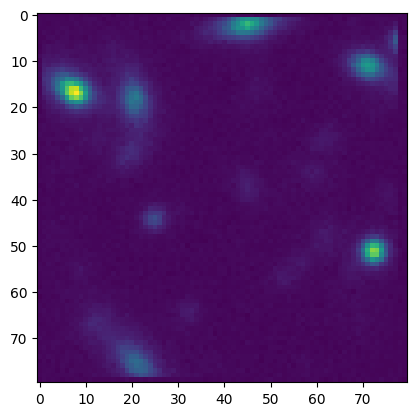

In [20]:
plt.imshow(ims[0][0]) #u-band for first of 64 images

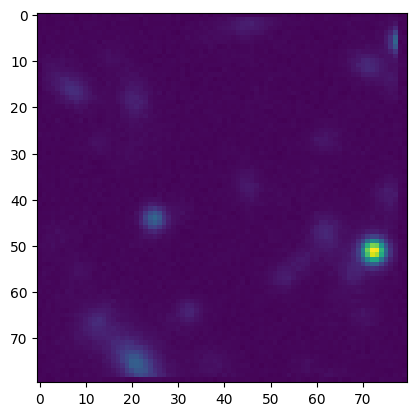

In [21]:
plt.imshow(ims[0][1]) #g-band for first of 64 images

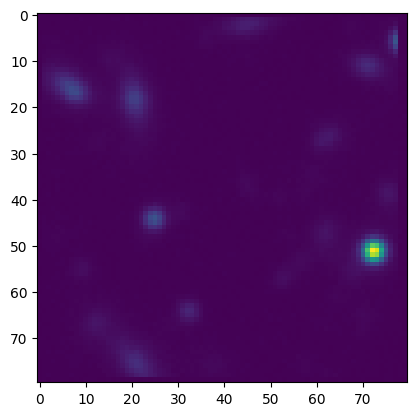

In [22]:
plt.imshow(ims[0][2]) #r-band for first of 64 images

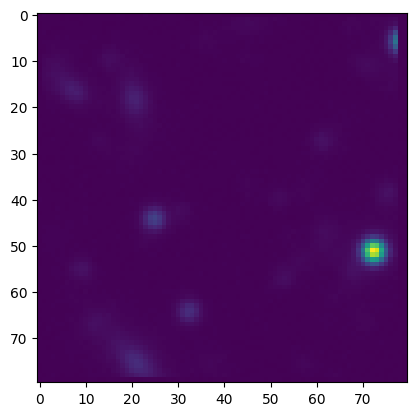

In [23]:
plt.imshow(ims[0][3]) #i-band for first of 64 images

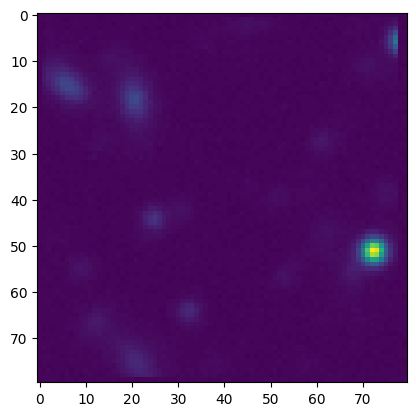

In [24]:
plt.imshow(ims[0][4]) #z-band for first of 64 images

## Your task: dive into the method `.get_batch()` that is used to generate these images. See how this method and methods it calls use the `flux` parameters from the tile catalog. Overwrite these fluxes to change the brightnesses of the resulting objects. You should be able to see this effect in each band.

You will want to start maybe with the `render_star`, `render_galaxy`, and `render_image` functions in the image decoder. You can modify code as needed, e.g. hardcode a single tile-catalog and alter it to explore the different renderings.